In [2]:
# working environment
!nvidia-smi

Wed Apr 12 15:17:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   43C    P5               41W / 390W|    227MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## <font color='red'>Import the necessary libraries</font>

In [44]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

# Read datasets

In [4]:
!ls

USHealthInsurance.ipynb  insurance.csv


In [5]:
insurance = pd.read_csv("insurance.csv")

In [6]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Extract some information from the data

In [45]:
new_insurance = pd.get_dummies(insurance)

In [46]:
new_insurance = new_insurance.dropna().astype(float)

In [47]:
new_insurance.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0.0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18.0,33.770,1.0,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28.0,33.000,3.0,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33.0,22.705,0.0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32.0,28.880,0.0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


# Separate input and label

In [48]:
Y = new_insurance.charges
X = new_insurance.drop(columns=["charges"])

# Split data for training and testing

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Data normalization

In [12]:
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)

x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)

# Put the data into a tensor slices

In [13]:
BATCH_SIZE = 32

train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2023-04-12 15:17:42.242699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22016 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


# Build our model

In [17]:
inputs = tf.keras.layers.Input(shape=(x_train.shape[1]))
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_3 (Dense)             (None, 256)               3072      
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,097
Trainable params: 36,097
Non-trainable params: 0
_________________________________________________________________


# Train our model

In [18]:
history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * 0.25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)])

Epoch 1/100


2023-04-12 15:18:14.000504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1070]
	 [[{{node Placeholder/_1}}]]
2023-04-12 15:18:15.289482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-12 15:18:15.295296: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f99b40389b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-12 15:18:15.295347: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-12 15:18:15.306188: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproduce

34/34 [==============================] - 3s 9ms/step - loss: 329516896.0000 - mae: 13394.4648 - val_loss: 320885280.0000 - val_mae: 12813.5029
Epoch 2/100
14/34 [===========>..................] - ETA: 0s - loss: 315988384.0000 - mae: 12771.4629

2023-04-12 15:18:16.388788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [268]
	 [[{{node Placeholder/_1}}]]


34/34 [==============================] - 0s 5ms/step - loss: 328838880.0000 - mae: 13374.7480 - val_loss: 319659744.0000 - val_mae: 12779.6748
Epoch 3/100
34/34 [==============================] - 0s 6ms/step - loss: 326670240.0000 - mae: 13317.0332 - val_loss: 316111200.0000 - val_mae: 12691.3906
Epoch 4/100
34/34 [==============================] - 0s 6ms/step - loss: 321159584.0000 - mae: 13183.3682 - val_loss: 308316032.0000 - val_mae: 12508.7109
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss: 310616096.0000 - mae: 12929.7998 - val_loss: 294492736.0000 - val_mae: 12191.8154
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 293155616.0000 - mae: 12517.2520 - val_loss: 273390528.0000 - val_mae: 11704.5000
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 269053952.0000 - mae: 11937.2236 - val_loss: 245262976.0000 - val_mae: 11031.5967
Epoch 8/100
34/34 [==============================] - 0s 6ms/step - loss: 236107616

Epoch 56/100
34/34 [==============================] - 0s 6ms/step - loss: 33692136.0000 - mae: 3723.3870 - val_loss: 30444040.0000 - val_mae: 3383.5852
Epoch 57/100
34/34 [==============================] - 0s 6ms/step - loss: 32295456.0000 - mae: 3661.8330 - val_loss: 30532738.0000 - val_mae: 3388.0305
Epoch 58/100
34/34 [==============================] - 0s 6ms/step - loss: 32700784.0000 - mae: 3659.3623 - val_loss: 30551966.0000 - val_mae: 3386.8430
Epoch 59/100
34/34 [==============================] - 0s 6ms/step - loss: 33018936.0000 - mae: 3653.6982 - val_loss: 30484570.0000 - val_mae: 3385.9377


# save the model

In [20]:
model.save("model-saved.h5")

# Plot the model training evaluation

<Axes: >

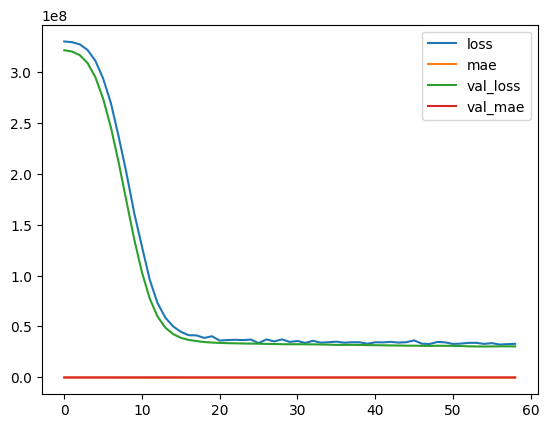

In [19]:
pd.DataFrame(history.history).plot()

# Load the model

In [ ]:
load_model = tf.keras.models.load_model("model-saved.h5")

# Test the model

In [22]:
perf = load_model.evaluate(test)
print("MAE: ", perf[1])

9/9 [==============================] - 0s 2ms/step - loss: 29666744.0000 - mae: 3549.0227
MAE:  3549.022705078125


# Plot our ground truth and prediction data

In [23]:
y_pred = load_model.predict(test)

9/9 [==============================] - 0s 1ms/step


In [25]:
y_pred[:10]

array([[ 2893.27  ],
       [10282.327 ],
       [23344.719 ],
       [14727.239 ],
       [12244.293 ],
       [34087.914 ],
       [39214.6   ],
       [ 3639.5967],
       [ 8325.538 ],
       [ 6527.449 ]], dtype=float32)

Text(0, 0.5, 'Charges')

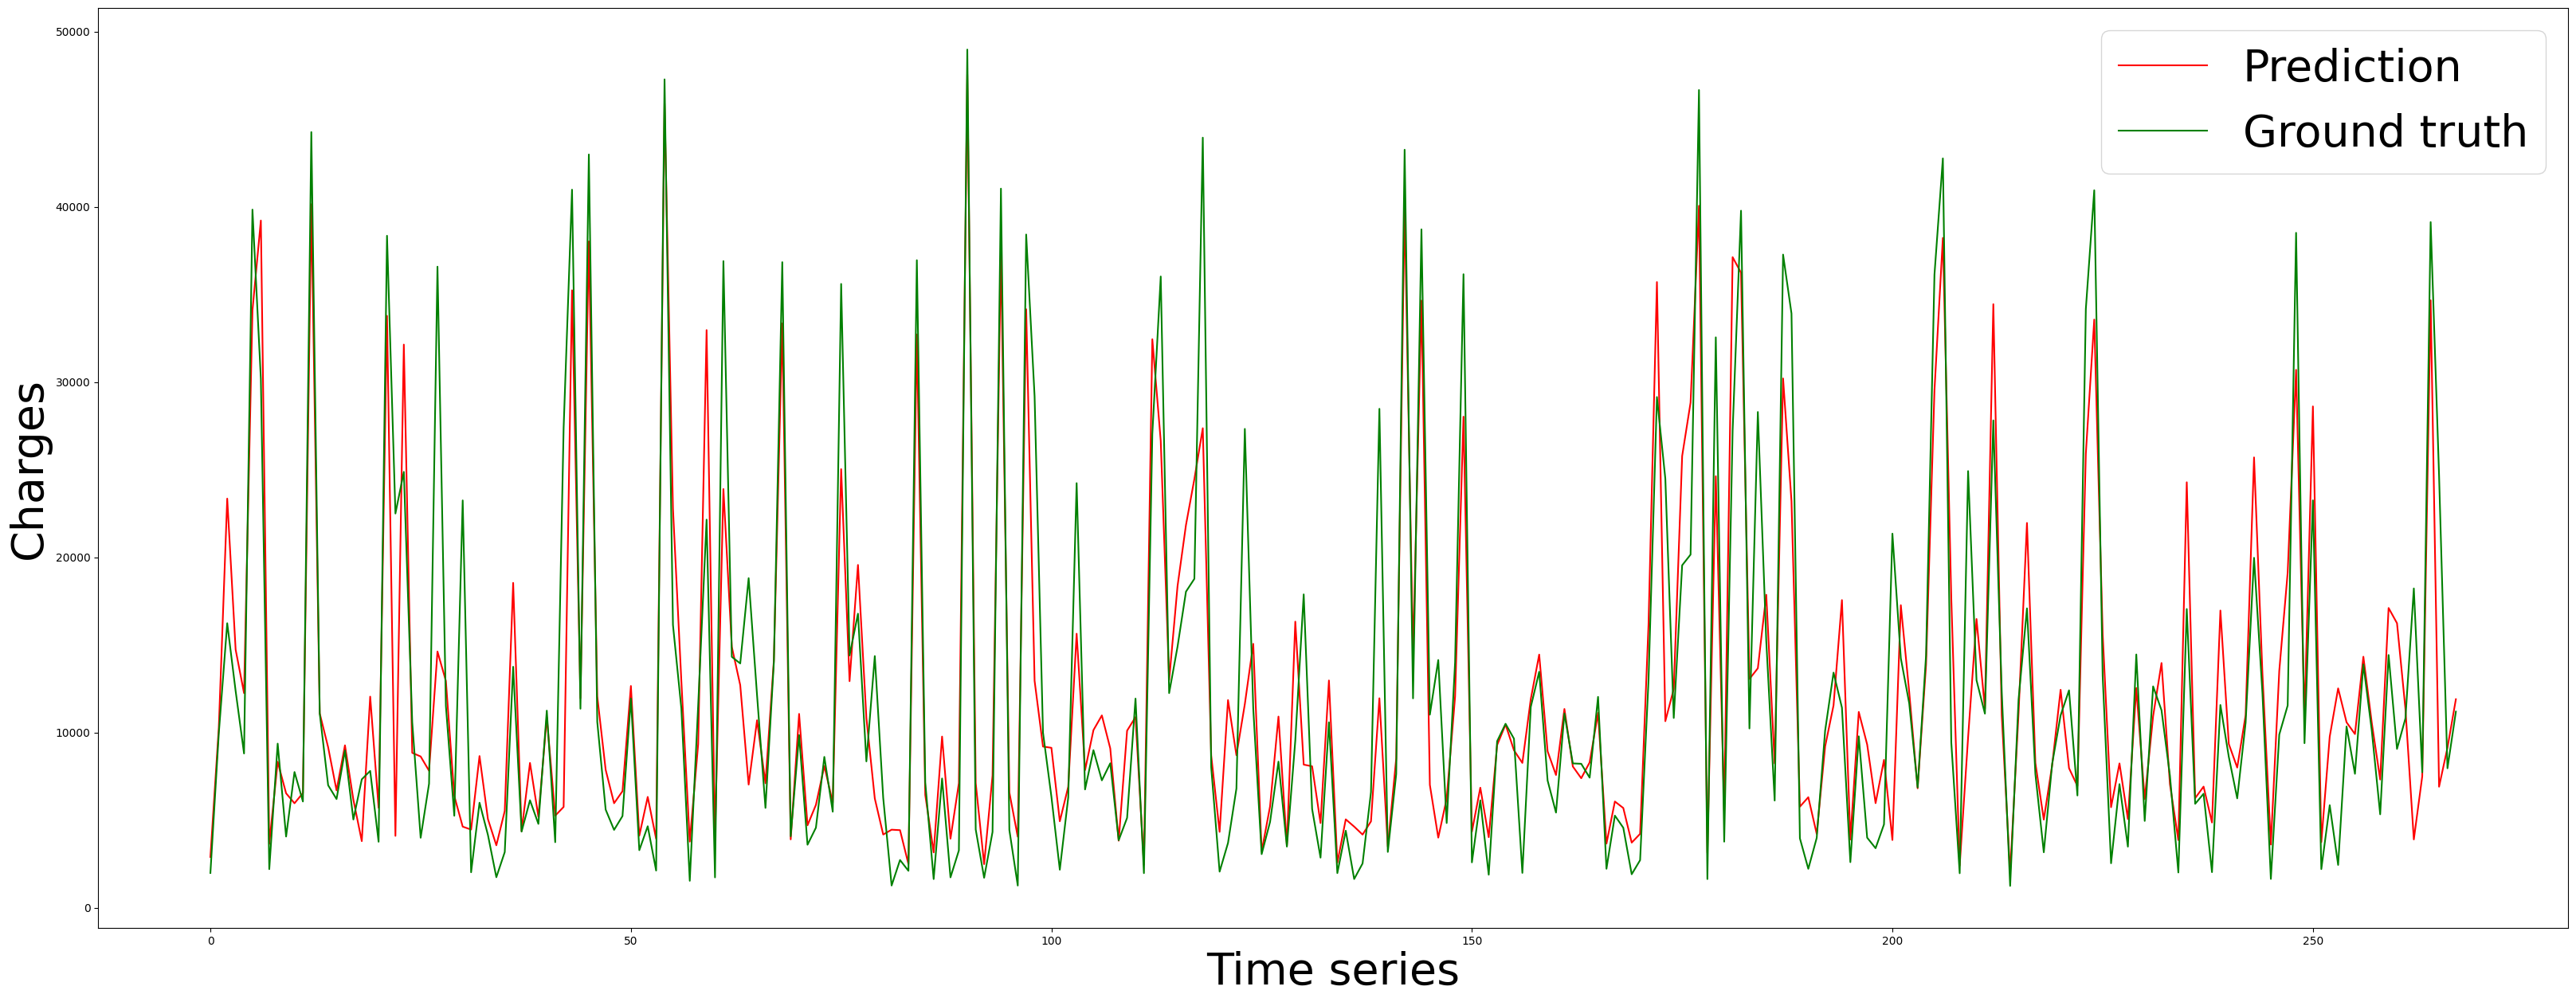

In [43]:
plt.figure(figsize=(40, 15)) 
plt.plot(y_pred.flatten(), c='red')
plt.plot(y_test.values, c='green')
plt.legend(["Prediction", "Ground truth"], fontsize=40)
plt.xlabel("Time series", fontsize=40)
plt.ylabel("Charges", fontsize=40)